In [4]:
import os
import builtins
import pandas as pd
# for wide terminal display of pandas dataframes
pd.options.display.width = 120
pd.options.display.max_rows = 10000
import scipy as sp
import numpy as np
import seaborn as sb
import statsmodels.tsa.arima_model as arima
import statsmodels.tsa.stattools as stattools
import statsmodels.tsa.statespace.sarimax as sarimax

# set project working directory
os.chdir( '/users/davidkarapetyan/documents/workspace/data_analysis/' )
# plot inline
%matplotlib inline
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 14, 6

# load r interaction
%reload_ext rpy2.ipython

In [5]:
park_data = pd.read_csv( 'data/park345_steam.csv' )
park_data = park_data.sort( 'TIMESTAMP' )


# ditch some entries 
park_data = park_data.loc[:,['TIMESTAMP', 'VALUE']]

# construct time series, getting rid of microseconds
temp = pd.Series( list( park_data.VALUE ),
                    pd.DatetimeIndex( park_data.TIMESTAMP ),
                    name = "steam values" )


park_ts = temp[temp != 0].resample( '15Min ', fill_method = 'pad' )
park_ts

2013-03-20 08:30:00     94.000000
2013-03-20 08:45:00     99.500000
2013-03-20 09:00:00    104.699997
2013-03-20 09:15:00    109.650002
2013-03-20 09:30:00    114.849998
2013-03-20 09:45:00    120.050003
2013-03-20 10:00:00    124.949997
2013-03-20 10:15:00    130.000000
2013-03-20 10:30:00    134.949997
2013-03-20 10:45:00    139.899994
2013-03-20 11:00:00    144.699997
2013-03-20 11:15:00    149.600006
2013-03-20 11:30:00    154.250000
2013-03-20 11:45:00    158.600006
2013-03-20 12:00:00    162.750000
2013-03-20 12:15:00    167.000000
2013-03-20 12:30:00    171.250000
2013-03-20 12:45:00    175.449997
2013-03-20 13:00:00    179.550003
2013-03-20 13:15:00    183.449997
2013-03-20 13:30:00    187.500000
2013-03-20 13:45:00    191.500000
2013-03-20 14:00:00    195.500000
2013-03-20 14:15:00    199.600006
2013-03-20 14:30:00    203.649994
2013-03-20 14:45:00    207.550003
2013-03-20 15:00:00    211.550003
2013-03-20 15:15:00    215.550003
2013-03-20 15:30:00    219.500000
2013-03-20 15:

In [6]:
# test for stationarity
if ( stattools.adfuller( park_ts )[1] > 0.05 ):
    print( "May be non-stationary after taking first lag" )

In [7]:
#function to find optimal ARIMA order

def arima_aic( endog, order ):
    return arima.ARIMA(endog, order).fit().aic
    

optimal_order_park = tuple( 
                      map( int,
                          sp.optimize.brute( lambda x: arima_aic( park_ts, x ),
                                ranges = ( slice( 0, 2, 1 ),
                                slice( 0, 2, 1 ),
                                slice( 0, 2, 1 ) ),
                                finish = None )
                          )
                      )


arima.ARIMA( park_ts, optimal_order_park ).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.steam values   No. Observations:                31550
Model:                 ARIMA(1, 1, 1)   Log Likelihood             -163533.409
Method:                       css-mle   S.D. of innovations             43.135
Date:                Wed, 01 Jul 2015   AIC                         327074.817
Time:                        17:40:33   BIC                         327108.255
Sample:                    03-20-2013   HQIC                        327085.520
                         - 02-12-2014                                         
========================================================================================
                           coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
const                    0.0021      0.005      0.413      0.679        -0.008     0.012
ar.L1.D.steam values     0.9718      0.001    713.390      0.000         0.969     0.974
ma.L1.D.steam values    -0.9994      0.000  -6203.265      0.000        -1.000    -0.999
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0291           +0.0000j            1.0291            0.0000
MA.1            1.0006           +0.0000j            1.0006            0.0000
-----------------------------------------------------------------------------
"""

We see that ARIMA is not currently fitting the time series data. We look for an appropriate transformation of the time series to improve our ARIMA fitting.t

###Log Ratio Transformation

In [8]:
park_ts_logr = (np.log(park_ts/park_ts.shift(1)))[1:]

To get a properly scaled plot, we filter out the outlier values occuring at the end of day (shift from some steam usage to none at all as systems restart, and spikes from ramp-up time at the beginning of the day). 

In [9]:
park_ts_logr.describe(percentiles = [0.05, 0.95])

count    31550.000000
mean         0.000028
std          0.641424
min         -8.194782
5%           0.000827
50%          0.032174
95%          0.236389
max          2.136600
Name: steam values, dtype: float64

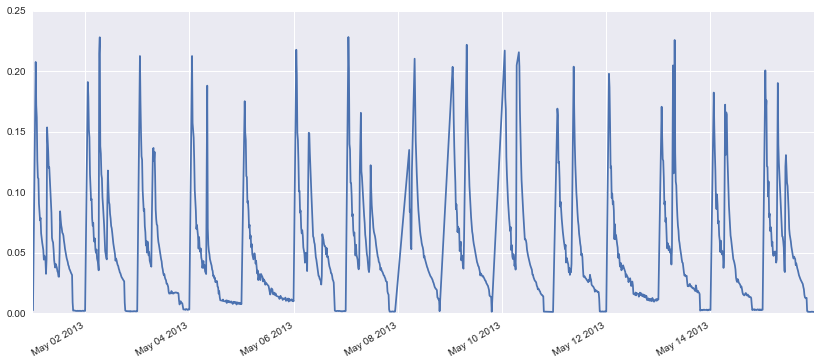

In [10]:
park_ts_logr[(park_ts_logr > 0.001) & (park_ts_logr < 0.23)]['2013-05-01': '2013-05-15'].plot()

The seasonality is clear. We now plot a single day, filtering out outliers to get a properly scaled figure.

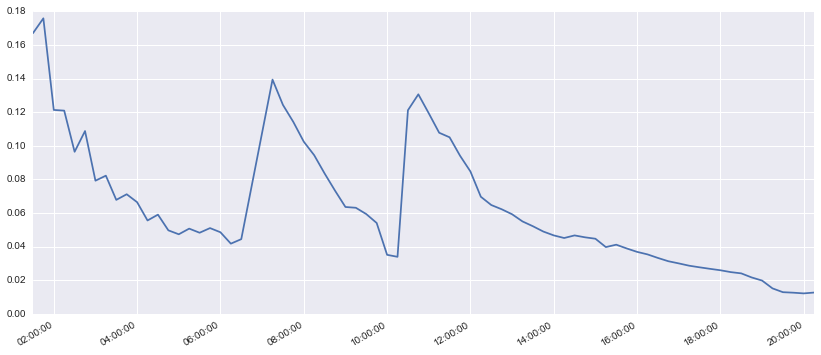

In [11]:
park_ts_logr[(park_ts_logr > 0.005) & (park_ts_logr < 0.18)]['2013-05-15'].plot()

Next, we utilise a SARIMAX model, with seasonality at 96 (our data points are spaced at 15 minute intervals), and analyze a week's worth of data (starting on Monday, and ending on Friday).

In [16]:
sarimax.SARIMAX(park_ts_logr['2013-05-06':'2013-05-10'], 
                       seasonal_order=(0,1,0,96)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                       steam values   No. Observations:                  480
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 96)   Log Likelihood                -455.090
Date:                            Wed, 01 Jul 2015   AIC                            914.180
Time:                                    17:41:15   BIC                            922.528
Sample:                                05-06-2013   HQIC                           917.462
                                     - 05-10-2013                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1         -0.1445      0.050     -2.884      0.004        -0.243    -0.046
sigma2         0.6265      0.043     14.566      0.000         0.542     0.711
==============================================================================
"""

While the fit isn't terrible, it can be improved by first observing that we have spikes in our at the beginning of the day. This is due to the ratio of chilled water temperature dipping suddenly at the end of day as systems are ramped down. 

Observe that the only negative values in the data occur at the start of day. We filter these out, and re-run SARIMA.

In [13]:
park_fit_week_filt = sarimax.SARIMAX(
    park_ts_logr[park_ts_logr > 0]['2013-05-06':'2013-05-10'], 
    seasonal_order = (0,1,0,95)).fit()

park_fit_week_filt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                       steam values   No. Observations:                  455
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 95)   Log Likelihood                 125.196
Date:                            Wed, 01 Jul 2015   AIC                           -246.391
Time:                                    17:40:37   BIC                           -238.151
Sample:                                05-06-2013   HQIC                          -243.145
                                     - 05-10-2013                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1          0.5039      0.038     13.276      0.000         0.430     0.578
sigma2         0.0292      0.002     13.351      0.000         0.025     0.033
==============================================================================
"""

Observe that the sarimax model seems to fit nicely now that we have filtered out the beginning-of-day spike. Now, let's use a larger input (beginning on a Monday, and ending on a Friday), and fit another Sarimax model to our beginning-of-day spike-filtered data. 

In [18]:
sarimax.SARIMAX(
    park_ts_logr[park_ts_logr > 0]['2013-05-06':'2013-06-07'], 
    seasonal_order = (0,1,0,95)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                       steam values   No. Observations:                 3112
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 95)   Log Likelihood                3325.059
Date:                            Wed, 01 Jul 2015   AIC                          -6646.118
Time:                                    17:42:03   BIC                          -6634.032
Sample:                                05-06-2013   HQIC                         -6641.779
                                     - 06-07-2013                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1          0.5443      0.012     44.757      0.000         0.521     0.568
sigma2         0.0065      0.000     38.644      0.000         0.006     0.007
==============================================================================
"""

This is an even better fit than the fit for the week's worth of data. Lastly, we input three
months worth of data, beginning on a Monday, and ending on a Friday.

In [12]:
sarimax.SARIMAX(park_ts_logr[park_ts_logr > 0]['2013-05-06': '2013-08-08'],
                                 seasonal_order = (0,1,0,95)).fit().summary()

Statespace Model Results 
 
 Dep. Variable: steam values No. Observations: 8898 
 
 
 Model: SARIMAX(1, 0, 0)x(0, 1, 0, 95) Log Likelihood 9085.122 
 
 
 Date: Wed, 01 Jul 2015 AIC -18166.243 
 
 
 Time: 15:31:47 BIC -18152.056 
 
 
 Sample: 05-06-2013 HQIC -18161.413 
 
 
 - 08-08-2013 
 
 
 
 
 coef std err z P>|z| [95.0% Conf. Int.] 
 
 
 ar.L1 0.5270 0.007 71.414 0.000 0.513 0.541 
 
 
 sigma2 0.0074 0.000 64.104 0.000 0.007 0.008

Let's contrast this with our fit when we include the end-of-day spikes:

In [13]:
sarimax.SARIMAX(park_ts_logr['2013-05-06': '2013-08-08'],
                                 seasonal_order = (0,1,0,96)).fit().summary()

Statespace Model Results 
 
 Dep. Variable: steam values No. Observations: 9120 
 
 
 Model: SARIMAX(1, 0, 0)x(0, 1, 0, 96) Log Likelihood -1620.493 
 
 
 Date: Wed, 01 Jul 2015 AIC 3244.986 
 
 
 Time: 15:38:32 BIC 3259.222 
 
 
 Sample: 05-06-2013 HQIC 3249.827 
 
 
 - 08-08-2013 
 
 
 
 
 coef std err z P>|z| [95.0% Conf. Int.] 
 
 
 ar.L1 -0.1199 0.010 -11.629 0.000 -0.140 -0.100 
 
 
 sigma2 0.0838 0.001 68.755 0.000 0.081 0.086

The excellent fit for even a large data set after filtering the ramp-up and ramp-down 15 minute spikes, and the poor fit when we keep them in, suggests that, apart from ramp-up and ramp-down times, the behavior of chilled water temperate is strongly linear. A possible future line of research is to investigate seasonality on a monthly level (for example, analyzing data in chunks of winter, spring, summer, fall), and so on, in order to attempt further improve fit.

However, from the looks of the data, it makes sense to keep the analysis of 15-minute ramp-up and ramp-down times separate from all other data. 

##SARIMAX on Data for Individual Days

We next investigate seasonality on a weekly basis. That is, we isolate the 5-day workweek into 5 chunks, and run SARIMAX on each chunk separately.

In [14]:
import datetime
index = park_ts_logr.index
park_ts_mon, park_ts_tue, park_ts_wed, park_ts_thu, park_ts_fri = [
    park_ts_logr[
        park_ts_logr.index[list(i for i in range(len(index)) if index[i].weekday()==j )]]
        for j in range(5)]

In [15]:
sarimax.SARIMAX(park_ts_mon[park_ts_mon > 0]['2013-05': '2013-08'],
                                 seasonal_order = (0,1,0,95)).fit().summary()

Statespace Model Results 
 
 Dep. Variable: steam values No. Observations: 1612 
 
 
 Model: SARIMAX(1, 0, 0)x(0, 1, 0, 95) Log Likelihood 1486.510 
 
 
 Date: Wed, 01 Jul 2015 AIC -2969.019 
 
 
 Time: 15:38:55 BIC -2958.249 
 
 
 Sample: 05-06-2013 HQIC -2965.021 
 
 
 - 08-26-2013 
 
 
 
 
 coef std err z P>|z| [95.0% Conf. Int.] 
 
 
 ar.L1 0.4053 0.021 19.573 0.000 0.365 0.446 
 
 
 sigma2 0.0082 0.000 28.883 0.000 0.008 0.009

As expected, the fit is good, but not as good as for our data set considering all days of the week. 
We suspect that this is due to there being fewer data points in the SARIMAX fitting above. To remedy this, we re-run SARIMAX on a larger data set of Mondays.

In [16]:
sarimax.SARIMAX(park_ts_mon[park_ts_mon > 0]['2013-03': '2014-02'],
                               seasonal_order = (0,1,0,95)).fit().summary()

Statespace Model Results 
 
 Dep. Variable: steam values No. Observations: 4451 
 
 
 Model: SARIMAX(1, 0, 0)x(0, 1, 0, 95) Log Likelihood 5259.987 
 
 
 Date: Wed, 01 Jul 2015 AIC -10515.974 
 
 
 Time: 15:39:06 BIC -10503.172 
 
 
 Sample: 03-25-2013 HQIC -10511.461 
 
 
 - 02-10-2014 
 
 
 
 
 coef std err z P>|z| [95.0% Conf. Int.] 
 
 
 ar.L1 0.3945 0.012 31.949 0.000 0.370 0.419 
 
 
 sigma2 0.0052 0.000 47.708 0.000 0.005 0.005

We do the same for Tuesdays, Wednesdays, etc.

In [17]:
sarimax.SARIMAX(park_ts_tue[park_ts_tue > 0]['2013-03': '2014-02'],
                               seasonal_order = (0,1,0,95)).fit().summary()

Statespace Model Results 
 
 Dep. Variable: steam values No. Observations: 4341 
 
 
 Model: SARIMAX(1, 0, 0)x(0, 1, 0, 95) Log Likelihood 5174.728 
 
 
 Date: Wed, 01 Jul 2015 AIC -10345.456 
 
 
 Time: 15:39:21 BIC -10332.704 
 
 
 Sample: 03-26-2013 HQIC -10340.955 
 
 
 - 02-11-2014 
 
 
 
 
 coef std err z P>|z| [95.0% Conf. Int.] 
 
 
 ar.L1 0.4816 0.011 43.035 0.000 0.460 0.504 
 
 
 sigma2 0.0051 0.000 48.372 0.000 0.005 0.005

In [18]:
#SARIMAX(0,1,0,95) MLE estimator doesn't converge

sarimax.SARIMAX(park_ts_wed[park_ts_wed > 0]['2013-03': '2014-02'],
                               seasonal_order = (1,0,0,95)).fit().summary()

Statespace Model Results 
 
 Dep. Variable: steam values No. Observations: 4351 
 
 
 Model: SARIMAX(1, 0, 0)x(1, 0, 0, 95) Log Likelihood 5325.219 
 
 
 Date: Wed, 01 Jul 2015 AIC -10644.439 
 
 
 Time: 15:39:50 BIC -10625.304 
 
 
 Sample: 03-20-2013 HQIC -10637.685 
 
 
 - 02-05-2014 
 
 
 
 
 coef std err z P>|z| [95.0% Conf. Int.] 
 
 
 ar.L1 0.5501 0.014 40.090 0.000 0.523 0.577 
 
 
 ar.S.L95 0.5958 0.013 45.085 0.000 0.570 0.622 
 
 
 sigma2 0.0050 0.000 46.391 0.000 0.005 0.005

In [19]:
sarimax.SARIMAX(park_ts_thu[park_ts_thu > 0]['2013-03': '2014-02'],
                               seasonal_order = (0,1,0,95)).fit().summary()

Statespace Model Results 
 
 Dep. Variable: steam values No. Observations: 4412 
 
 
 Model: SARIMAX(1, 0, 0)x(0, 1, 0, 95) Log Likelihood 4863.379 
 
 
 Date: Wed, 01 Jul 2015 AIC -9722.758 
 
 
 Time: 15:40:05 BIC -9709.974 
 
 
 Sample: 03-21-2013 HQIC -9718.249 
 
 
 - 02-06-2014 
 
 
 
 
 coef std err z P>|z| [95.0% Conf. Int.] 
 
 
 ar.L1 0.3523 0.013 27.683 0.000 0.327 0.377 
 
 
 sigma2 0.0062 0.000 46.219 0.000 0.006 0.006

In [20]:
sarimax.SARIMAX(park_ts_fri[park_ts_fri > 0]['2013-03': '2014-02'],
                               seasonal_order = (0,1,0,95)).fit().summary()

/Users/davidkarapetyan/Library/Python/3.4/lib/python/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Statespace Model Results 
 
 Dep. Variable: steam values No. Observations: 4443 
 
 
 Model: SARIMAX(1, 0, 0)x(0, 1, 0, 95) Log Likelihood 6164.675 
 
 
 Date: Wed, 01 Jul 2015 AIC -12325.349 
 
 
 Time: 15:40:32 BIC -12312.551 
 
 
 Sample: 03-22-2013 HQIC -12320.837 
 
 
 - 02-07-2014 
 
 
 
 
 coef std err z P>|z| [95.0% Conf. Int.] 
 
 
 ar.L1 0.4687 0.012 39.976 0.000 0.446 0.492 
 
 
 sigma2 0.0034 7.22e-05 47.581 0.000 0.003 0.004

##ARIMAX For Ramp-up and Ramp-Down

We shall treat Monday ramp-ups separately from the remaining days of the week, due to difference between system-idling over weekends and weekdays.

In [21]:
[park_ts_mon_spike, park_ts_tue_spike, park_ts_wed_spike,
 park_ts_thu_spike, park_ts_fri_spike] = [
    park_ts_logr[
        park_ts_logr.index[list(i for i in range(len(index)) 
                                if index[i].weekday()==j )]][park_ts_logr < 0]
        for j in range(5)]

arima.ARIMA(park_ts_mon_spike, order=(0,1,0)).fit().summary()

ARIMA Model Results 
 
 Dep. Variable: D.steam values No. Observations: 46 
 
 
 Model: ARIMA(0, 1, 0) Log Likelihood -69.892 
 
 
 Method: css S.D. of innovations 1.106 
 
 
 Date: Wed, 01 Jul 2015 AIC 143.784 
 
 
 Time: 15:40:37 BIC 147.441 
 
 
 Sample: 04-01-2013 HQIC 145.154 
 
 
 - 02-10-2014 
 
 
 
 
 coef std err z P>|z| [95.0% Conf. Int.] 
 
 
 const 0.0169 0.163 0.104 0.918 -0.303 0.336

Observe that between end of day and start of day, chilled water temperature decreases, and so $$\frac{T_k(0 + 00:15)}{T_k(0)} = a_k < 1$$ for each entry in our training set. The set $\{a_k\}_k$ will hopefully consist of entries that are clustered near one another, with some reasonable volatility. Taking a logarithm of them will result in an exponential increase in volatility, since $log(x)$ is an exponential function of $x$ for decreasing $x < 1$. This will result in decreasing the goodness-of-fit of a linear model, from a least-squares standpoint. Consequently, we exponentiate our time series data, and re-fit: 

In [22]:
arima.ARIMA(np.exp(park_ts_mon_spike), order=(0,1,0)).fit().summary2()

Model: ARIMA Log-Likelihood: 147.05 
 
 
 Dependent Variable: D.steam values Scale: 1.0000 
 
 
 Date: 2015-07-01 15:40 Method: css 
 
 
 No. Observations: 46 Sample: 04-01-2013 
 
 
 Df Model: 1 02-10-2014 
 
 
 Df Residuals: 45 S.D. of innovations: 0.010 
 
 
 AIC: -290.1060 HQIC: -288.736 
 
 
 BIC: -286.4487 
 
 
 
 
 Coef. Std.Err. t P>|t| [0.025 0.975] 
 
 
 const 0.0002 0.0015 0.1156 0.9085 -0.0027 0.0030

Observe that the fit has improved dramatically.

In [ ]:
lalalsdf lkja asdf